#### 라이브러리 불러오기

In [16]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from tensorflow.keras.callbacks import EarlyStopping

from climate_win_gen import WindowGen

#### 전처리 데이터 불러오기

In [2]:
_PATH_BASE = os.path.join(os.getcwd(), 'data')
_PATH_TRAIN = os.path.join(_PATH_BASE, 'climate_train.csv')
_PATH_VALID = os.path.join(_PATH_BASE, 'climate_valid.csv')
_PATH_TEST = os.path.join(_PATH_BASE, 'climate_test.csv')

try:
    df_train = pd.read_csv(_PATH_TRAIN)
    df_valid = pd.read_csv(_PATH_VALID)
    df_test = pd.read_csv(_PATH_TEST)
except Exception as e:
    print('훈련/검증/시험파일이 존재하지 않습니다.\n'
          '52-ts-climate-pp.ipynb 실행 후 작업하시기 바랍니다.')
    print(e)

#### 랩핑함수 생성

In [3]:
column_indices = {name: i for i, name in enumerate(df_train.columns)}

In [4]:
def make_win(input_width, label_width, shift, labels):
    return WindowGen(
        input_width=input_width,
        label_width=label_width,
        shift=shift,
        df_train=df_train,
        df_valid=df_valid,
        df_test=df_test,
        label_columns=labels
    )

#### 성능지표 관리 딕셔너리 정의

In [5]:
val_performance = {}
performance = {}

#### 단일스텝 모델

In [6]:
single_step_window = make_win(
    input_width=1, label_width=1, shift=1,
    labels=['T (degC)']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [7]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [8]:
model_baseline = Baseline(label_index=column_indices['T (degC)'])
model_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

2023-08-30 16:00:44.558379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22817 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-08-30 16:00:44.559366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22225 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


In [9]:
model_baseline.fit(single_step_window.train, epochs=10)

Epoch 1/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 2/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 3/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 4/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 5/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 6/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 7/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 8/10
1535/1535 [==============================] - 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0789
Epoch 9/10
1535/1535 [==============================] - 6s 4ms/step - loss: 0.0123 - mean_absolu

In [10]:
val_performance['Baseline'] = model_baseline.evaluate(single_step_window.valid)
performance['Baseline'] = model_baseline.evaluate(single_step_window.test)

220/220 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_error: nan


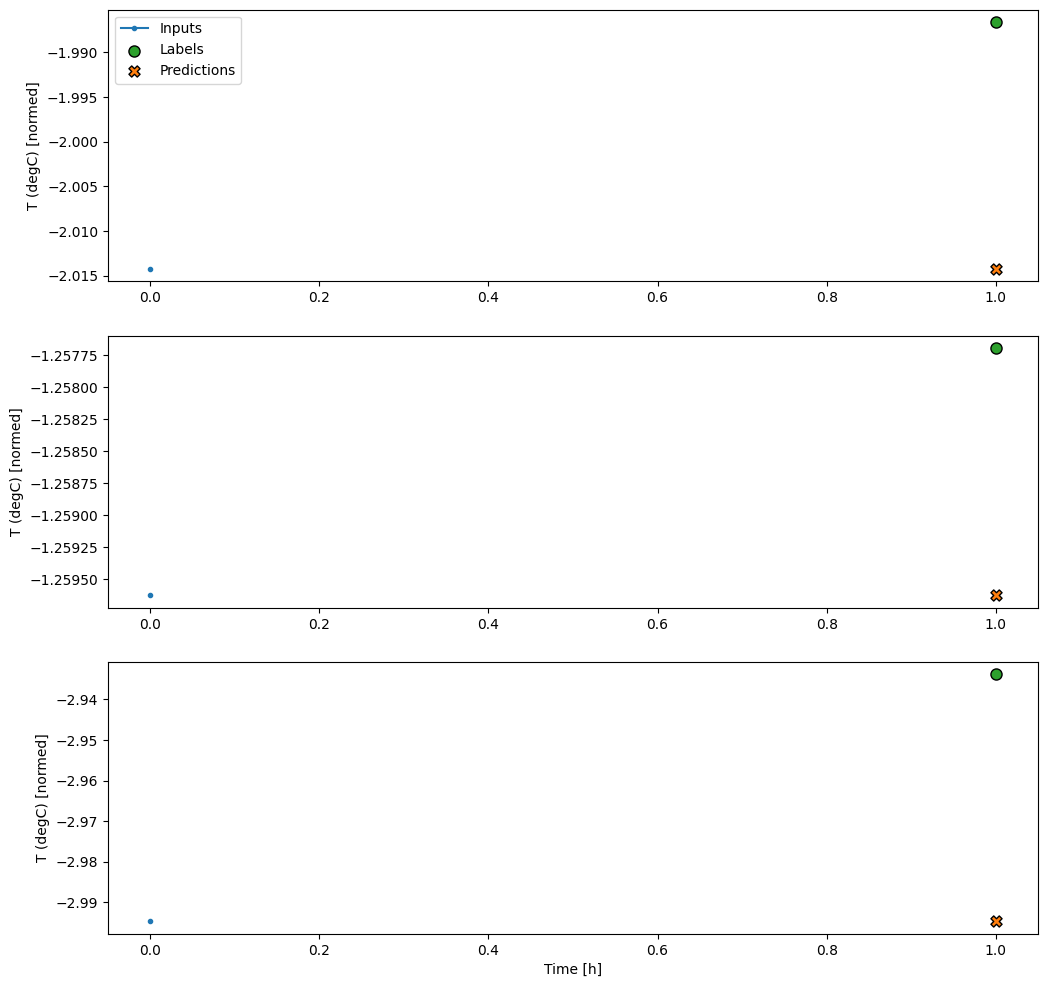

In [11]:
single_step_window.plot(model=model_baseline)

#### Wide Window 모델링

In [12]:
wide_window = make_win(
    input_width=24, label_width=24, shift=1,
    labels=['T (degC)']
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

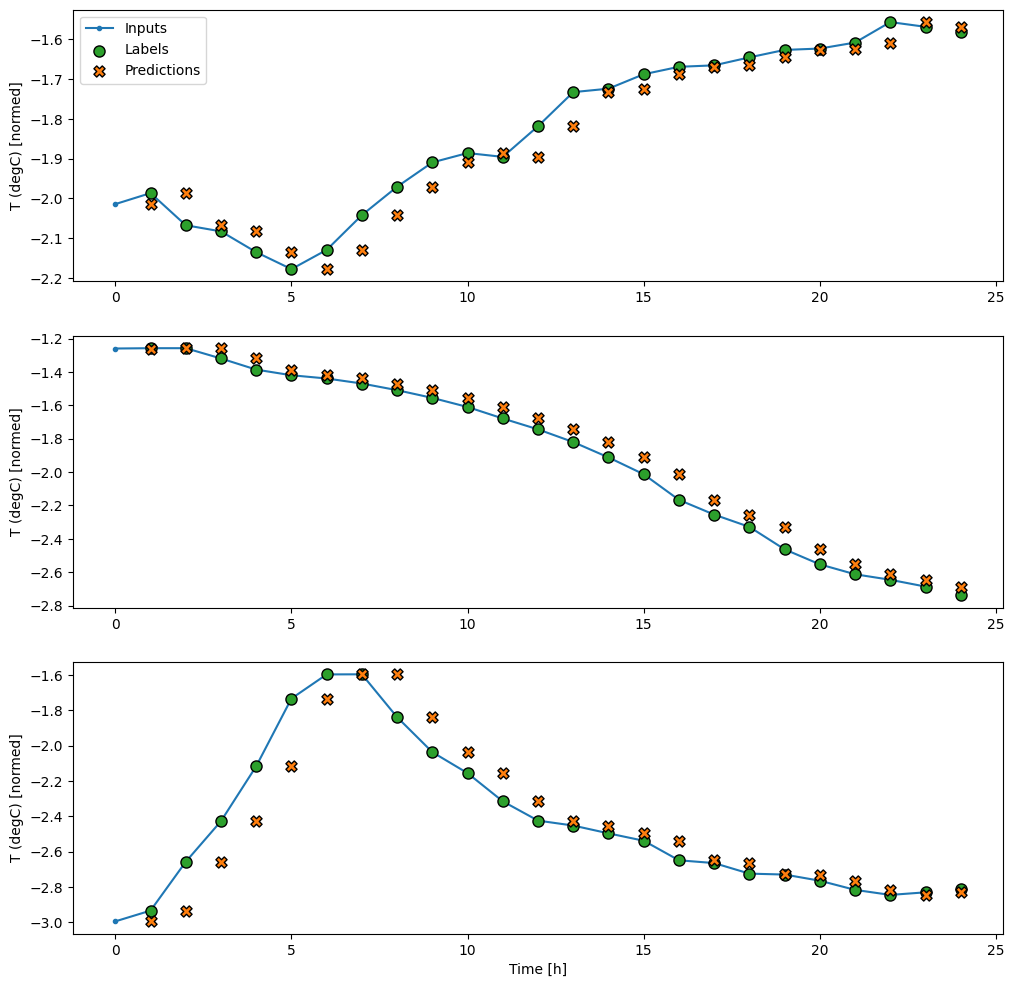

In [13]:
wide_window.plot(model=model_baseline)

#### fit함수 정의

In [15]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, mode='min'
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    
    return model.fit(       # return history
        window.train, 
        epochs=MAX_EPOCHS, 
        validation_data=window.valid,
        callbacks=[early_stopping]
    )

#### 선형모델

In [15]:
model_linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [16]:
history = compile_and_fit(model_linear, single_step_window)

val_performance['Linear'] = model_linear.evaluate(single_step_window.valid)
performance['Linear'] = model_linear.evaluate(single_step_window.test)

Epoch 1/20


2023-08-30 16:01:43.708733: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x29b01cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-30 16:01:43.708826: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2023-08-30 16:01:43.708851: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA TITAN RTX, Compute Capability 7.5
2023-08-30 16:01:43.726108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-30 16:01:43.993453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-30 16:01:44.088273: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   1/1535 [..............................] - ETA: 49:28 - loss: 2.1777 - mean_absolute_error: 1.1991

2023-08-30 16:01:44.219836: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1535/1535 [==============================] - 13s 7ms/step - loss: 0.2323 - mean_absolute_error: 0.2959 - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
220/220 [==============================] - 1s 5ms/step - loss: nan - mean_absolute_error: nan


In [17]:
history = compile_and_fit(model_linear, wide_window)

val_performance['Linear'] = model_linear.evaluate(wide_window.valid)
performance['Linear'] = model_linear.evaluate(wide_window.test)

Epoch 1/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0076 - mean_absolute_error: 0.0648 - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_error: nan


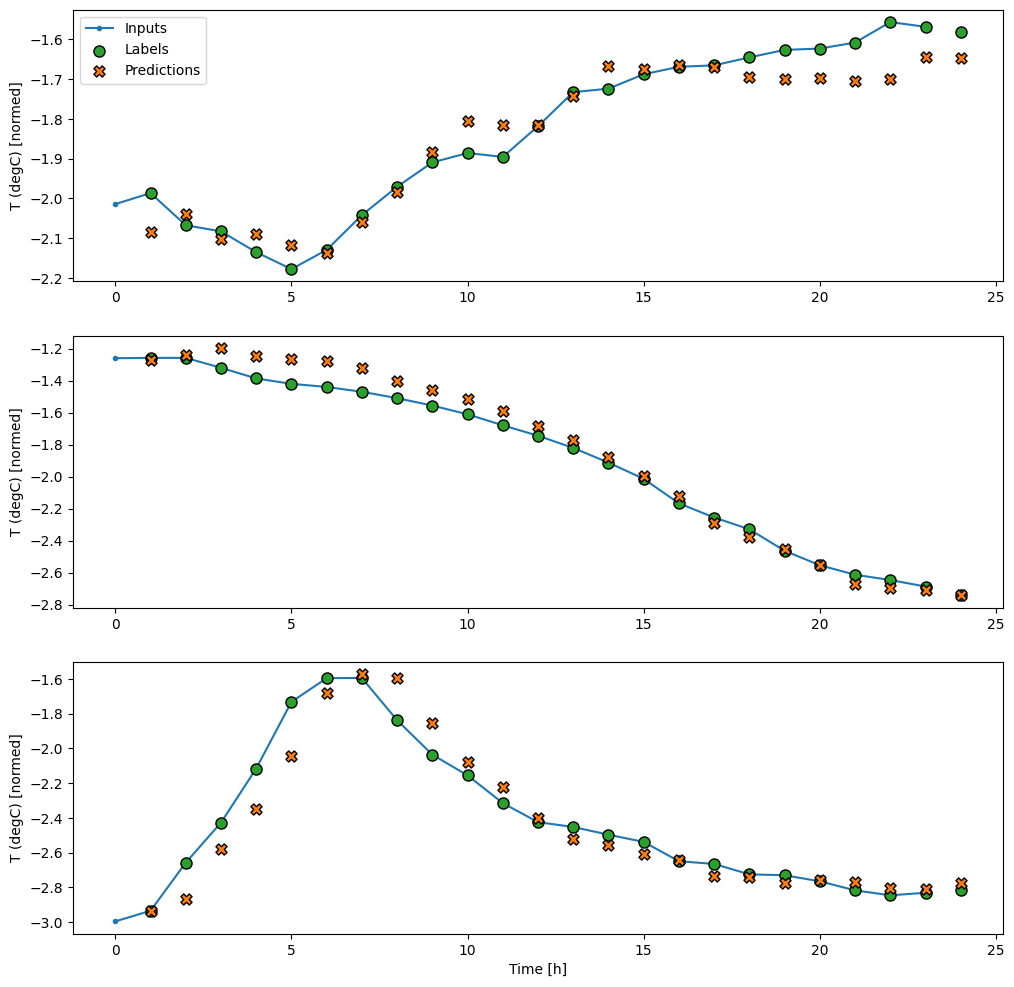

In [18]:
wide_window.plot(model_linear)

#### 다중 예측

In [6]:
OUT_STEPS = 24
multi_window = make_win(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, labels=['T (degC)']
)
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']

In [7]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [8]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

2023-08-30 16:22:43.637838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22817 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-08-30 16:22:43.638803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22242 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


437/437 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan


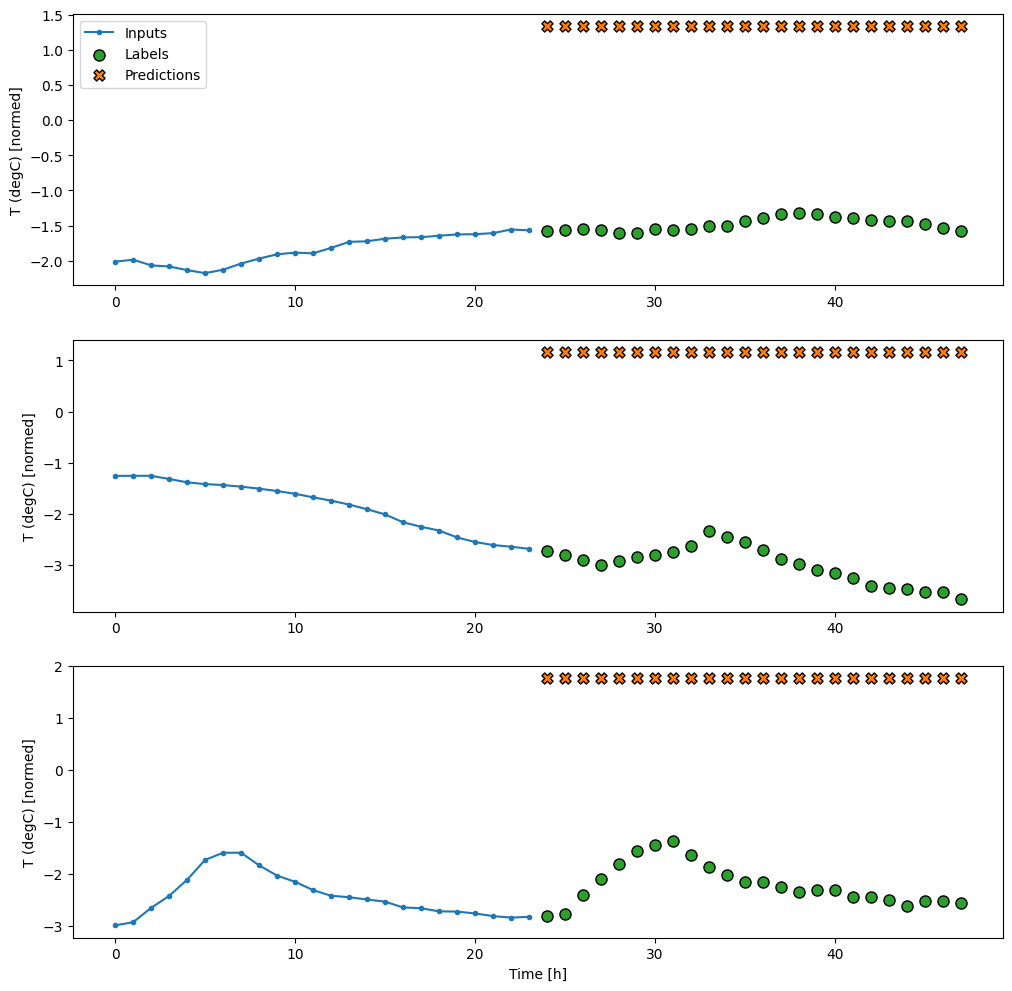

In [10]:
multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.valid)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

437/437 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan


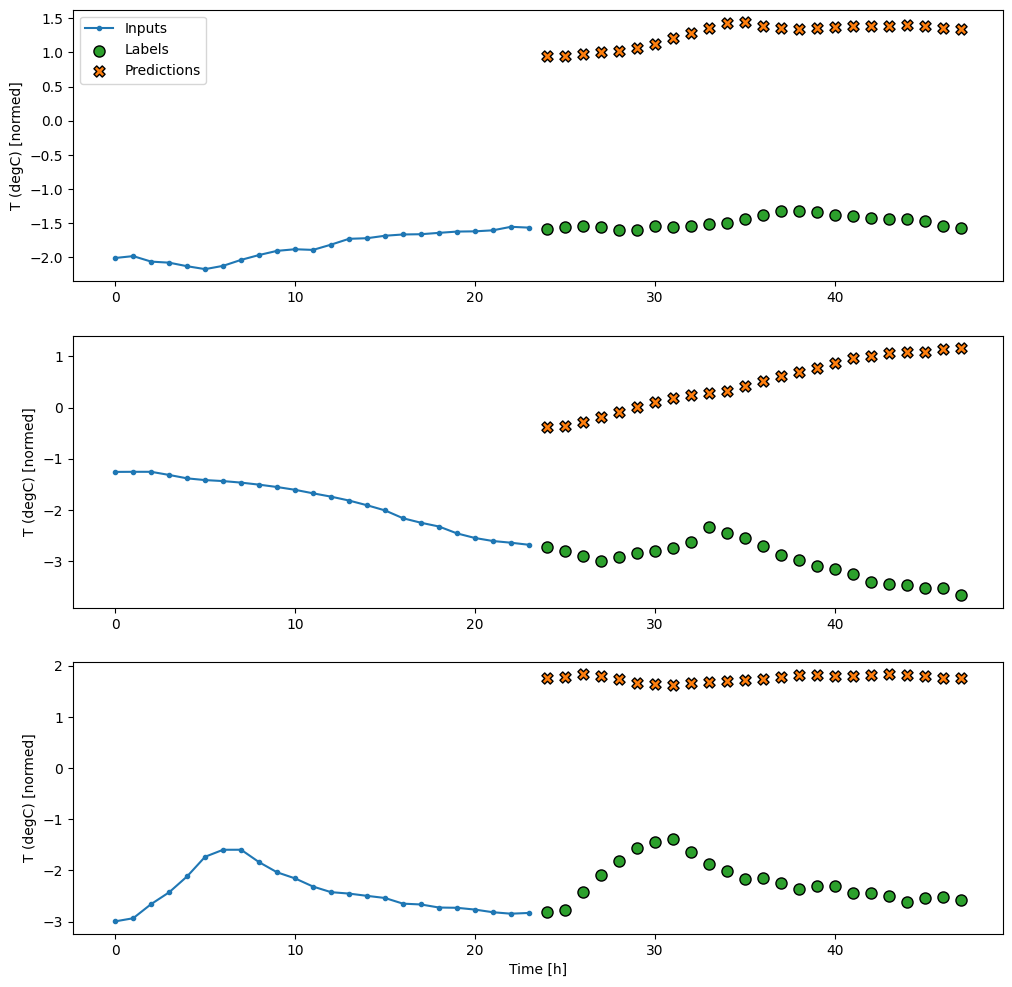

In [11]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.valid)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [13]:
num_features = df_train.shape[1]

437/437 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan


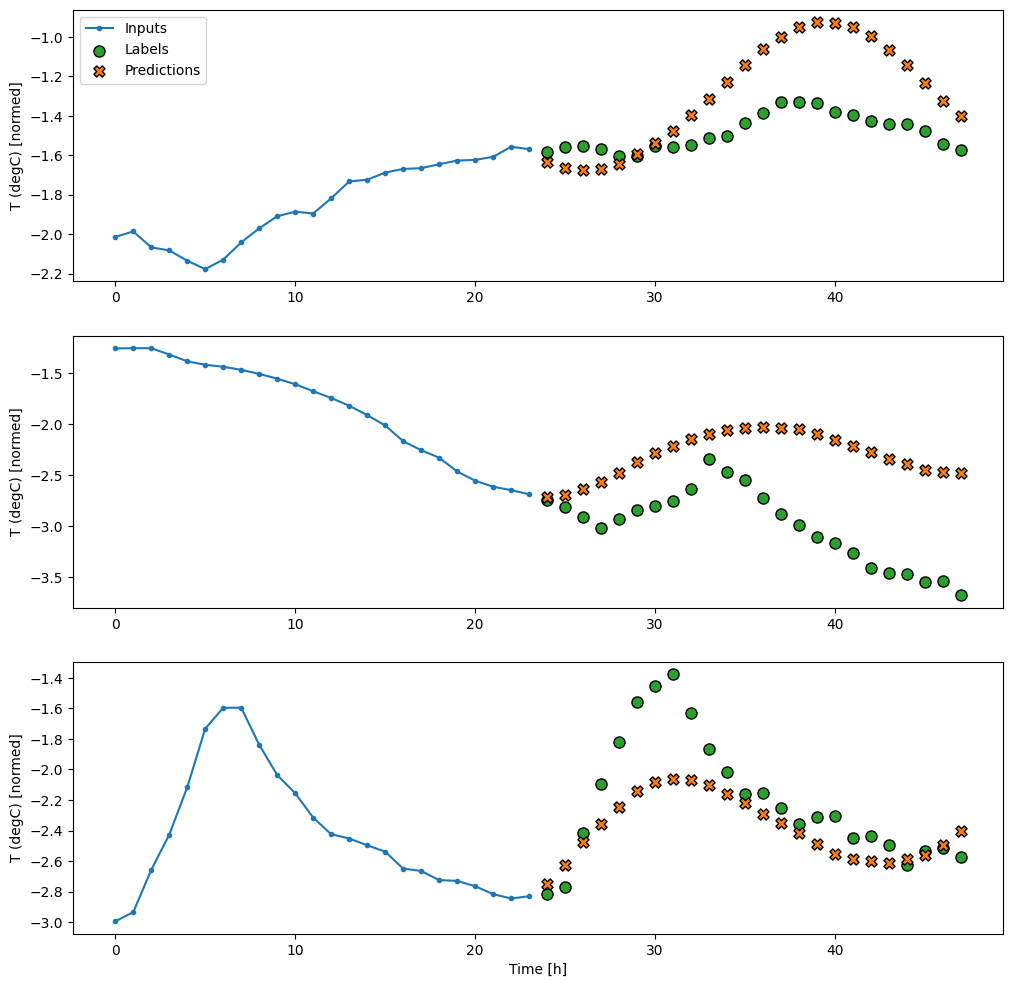

In [17]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.valid)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

437/437 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan


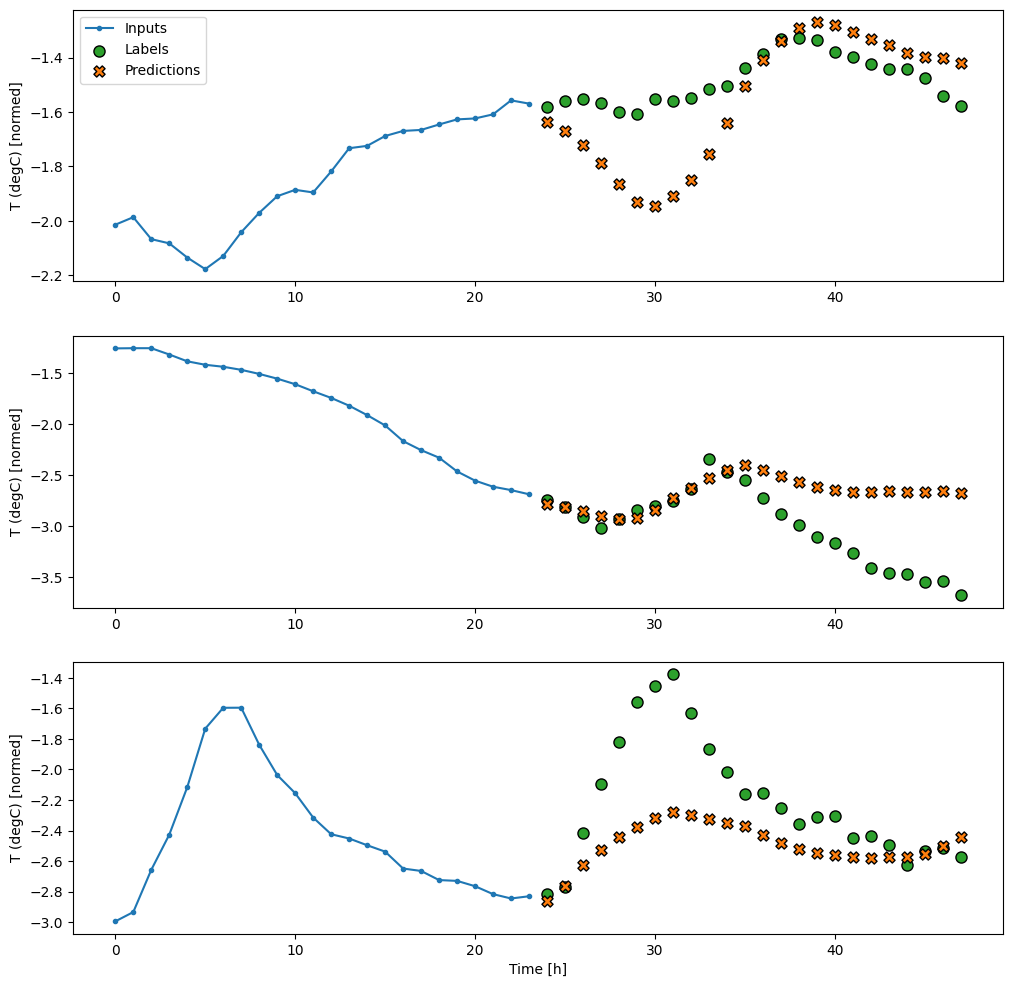

In [18]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.valid)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

437/437 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan


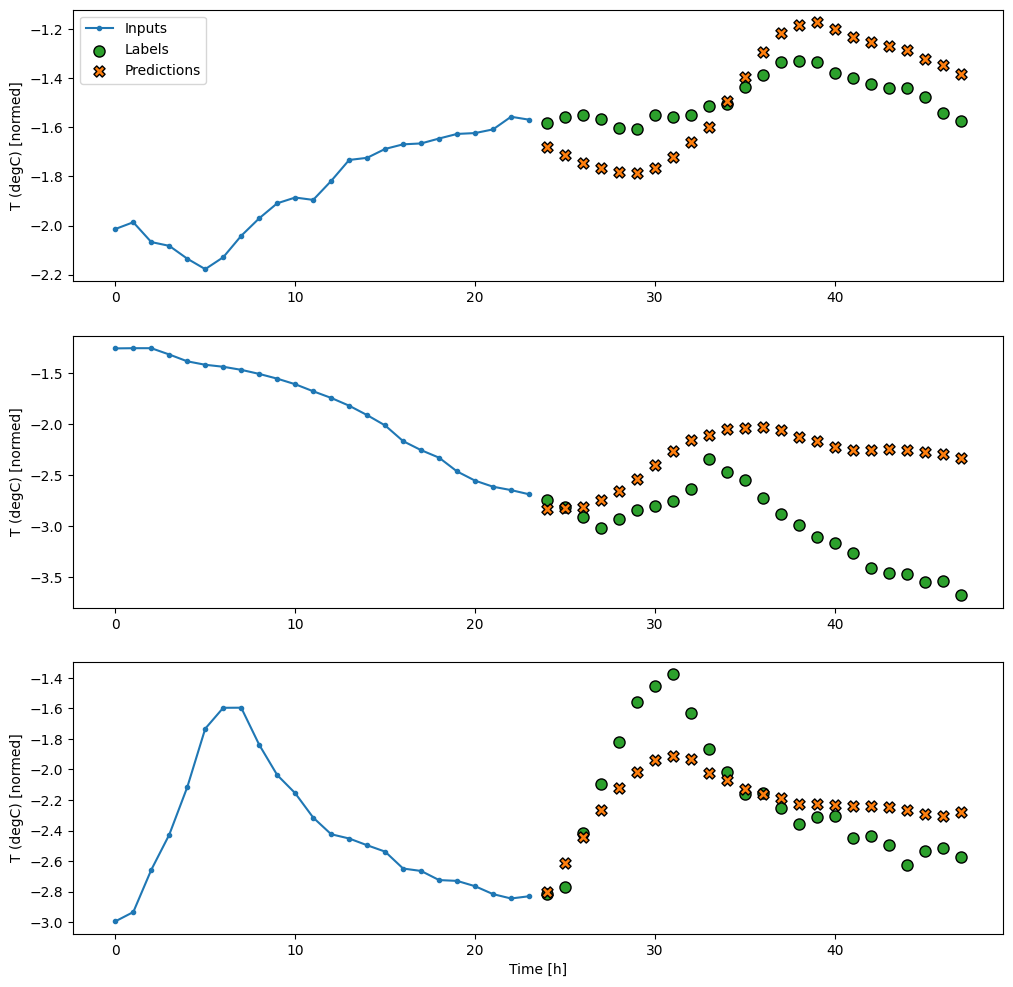

In [19]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

437/437 [==============================] - 3s 7ms/step - loss: nan - mean_absolute_error: nan


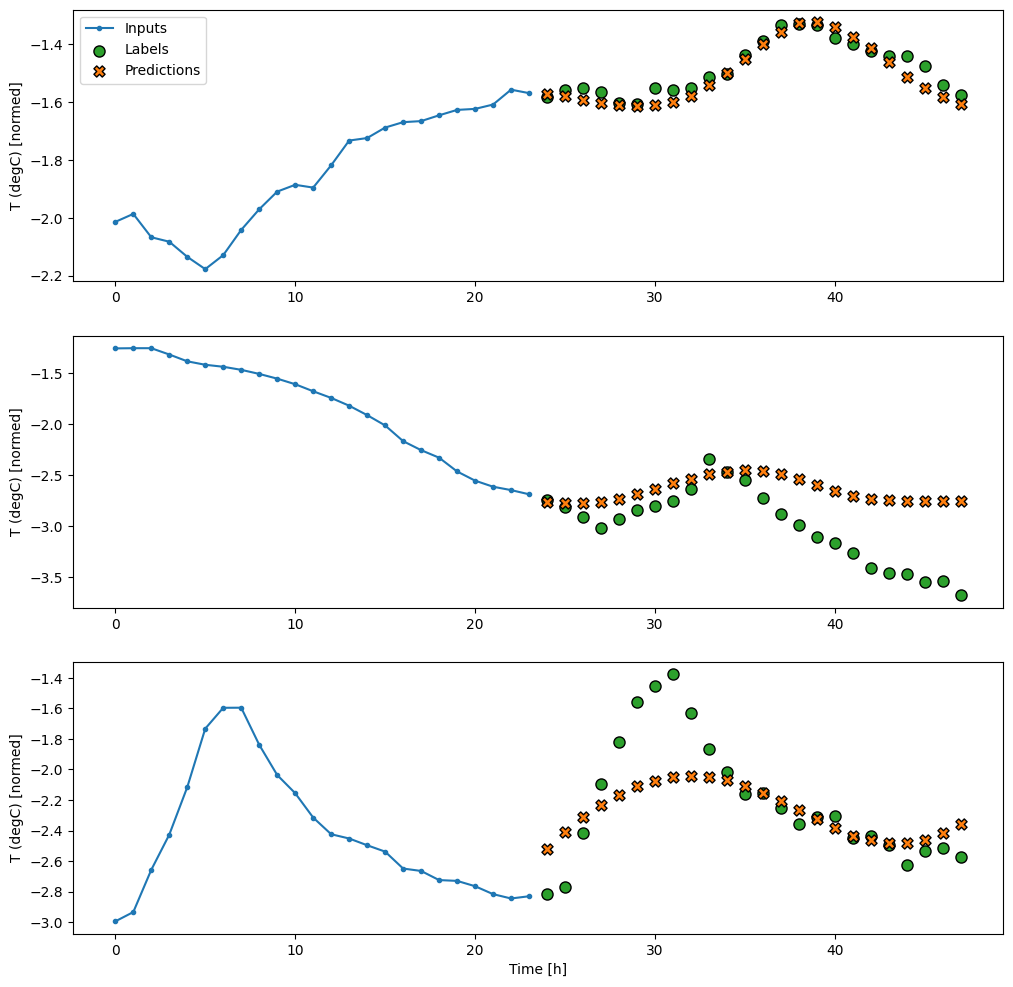

In [20]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

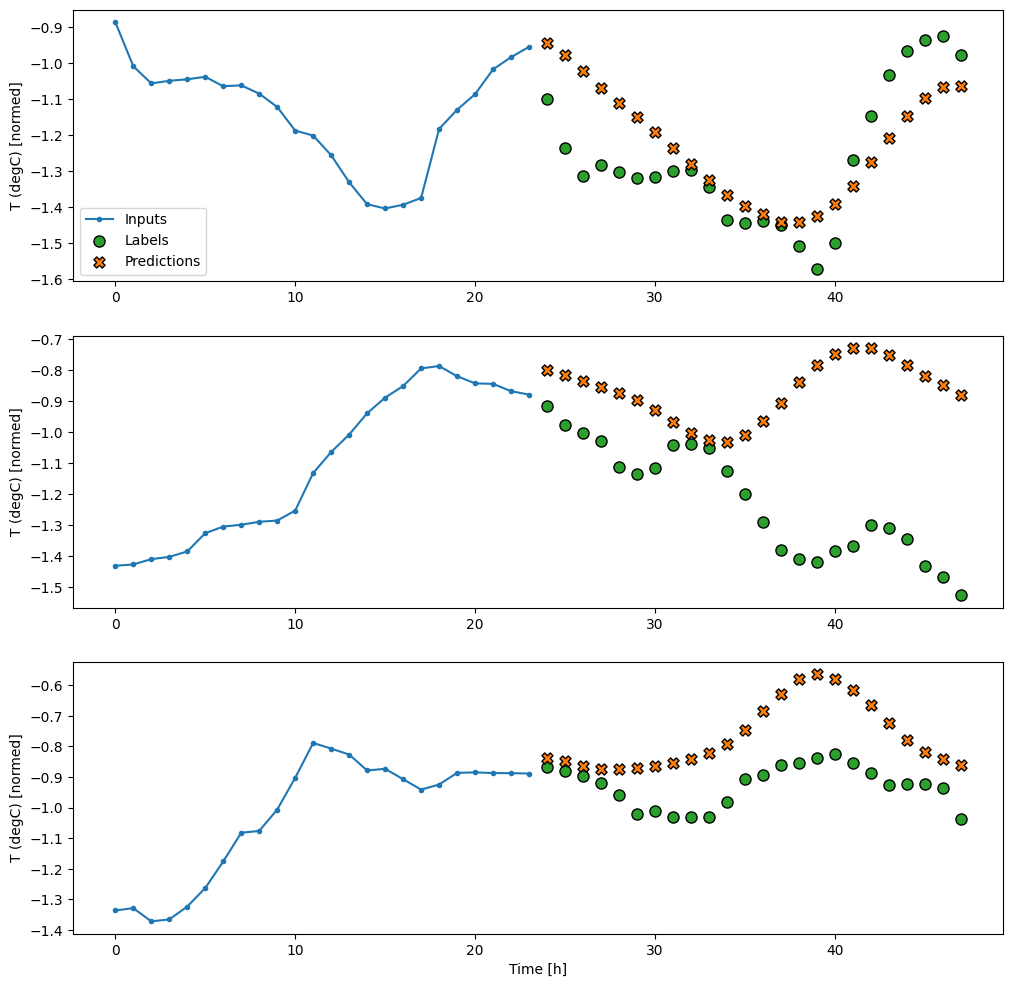

In [21]:
multi_window.plot(multi_lstm_model, start=1000)

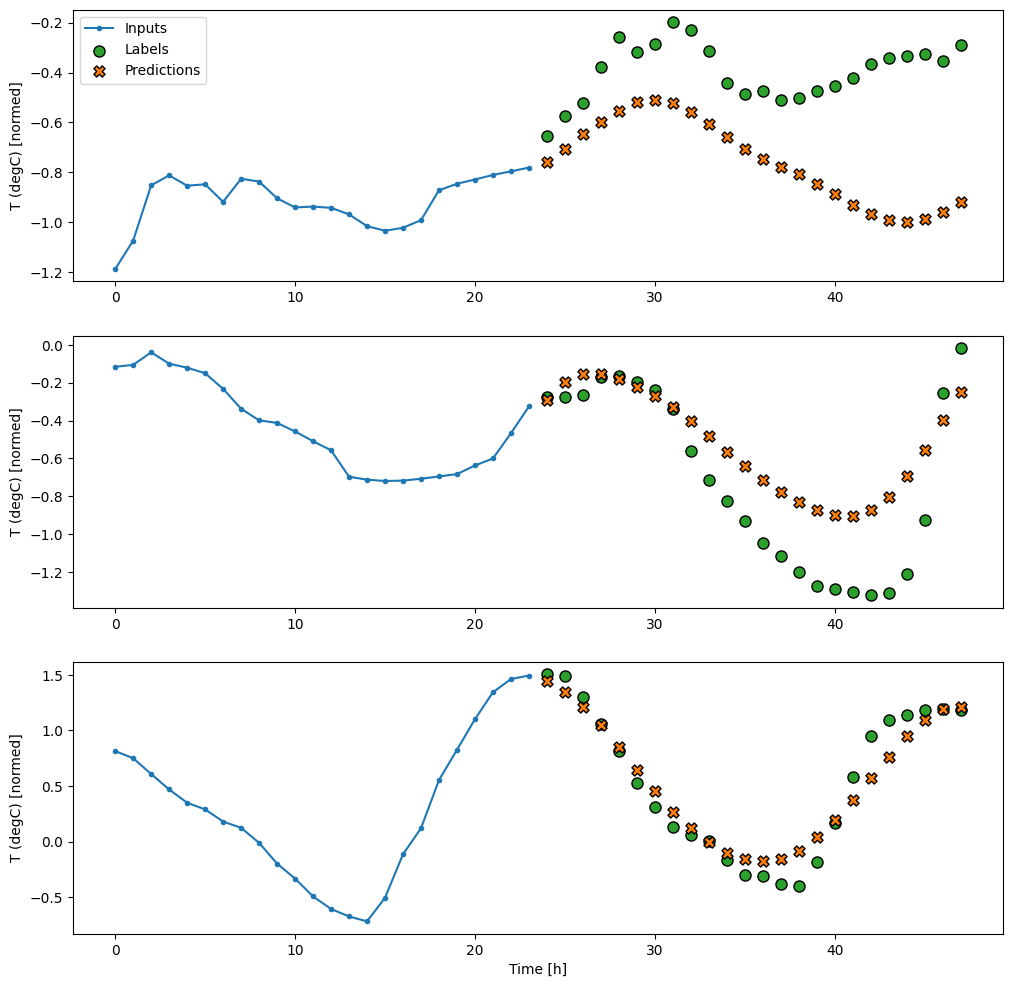

In [22]:
multi_window.plot(multi_lstm_model, start=2000)

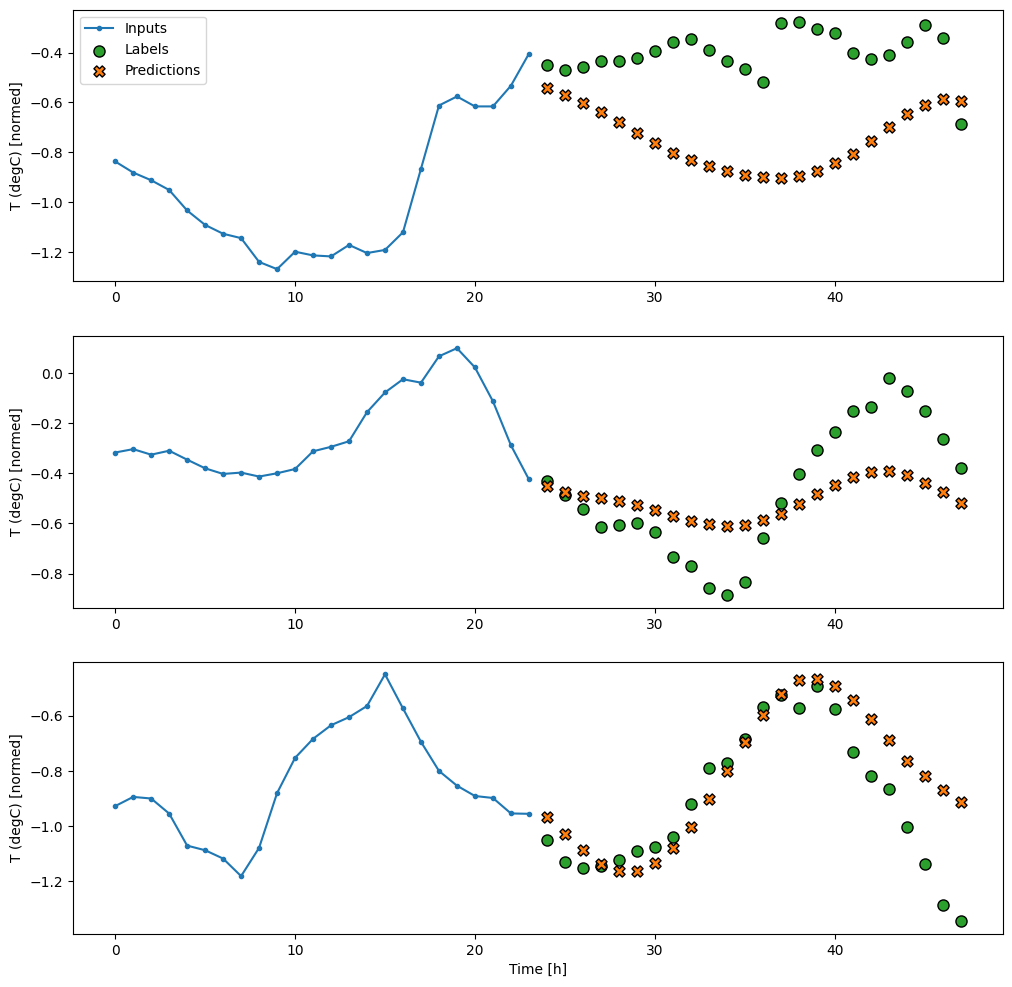

In [23]:
multi_window.plot(multi_lstm_model, start=10000)